# Petfinder.my competition: modelling, part one

## Introduction

## Libraries and misc function defs

In [1]:
import os
import itertools
from collections import Counter

import feather

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
def plot_average_confmatrix(confusion_matrices:list, normalise:bool=True):
    mean_confmatrix = confusion_matrix(y_train, np.round(np.mean(lgb_preds, axis=1)))
    if normalise:
        mean_confmatrix = mean_confmatrix.astype('float') / mean_confmatrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(mean_confmatrix, annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if normalise:
        plt.title('Normalised confusion matrix')
    else:
        plt.title('Confusion matrix')
    plt.show()

## Loading data

In [2]:
INPUT_PATH = os.path.join(os.pardir, 'data', 'interim')

In [3]:
all_train = feather.read_dataframe(os.path.join(INPUT_PATH, 'train.feather'))
all_test = feather.read_dataframe(os.path.join(INPUT_PATH, 'test.feather'))

## Preparing data

Splits the training data into training and validation data sets. The size of the validation data was calculated to match the size of the final unseen testing data relative to the original training data.

In [4]:
cat_colnames = ['RescuerID', 'PetID', 'PrimaryLabel', 'SecondaryLabel']

In [5]:
# Dealing with categorical data
all_data = [all_train, all_test]

for df in all_data:
    for col in cat_colnames:
        df[col] = pd.Categorical(df[col])
        df[col] = df[col].cat.codes
        df[col] = pd.Categorical(df[col])

In [6]:
drop_cols = ['Name', 'Description', 'AdoptionSpeed']

In [7]:
X_train = all_train.drop(drop_cols, axis=1)
y_train = all_train['AdoptionSpeed']

In [8]:
# X_train, X_valid, y_train, y_valid = train_test_split(training_data, training_labels,
#                                                      test_size=len(all_test) / len(all_train))

In [9]:
print(X_train.shape, y_train.shape)

(14993, 346) (14993,)


## LightGBM: classification model

Fits a LightGBM classification model.

### Scoring

The competition uses the quadratic weighted kappa for scoring.

In [10]:
def kappa_metric(predictions, actuals):
    """
    Competition scores are calculated with the quadratic weighted kappa.
    The cohen_kappa_score from sklearn.metrics is identical
    """
    return cohen_kappa_score(predictions, actuals, weights='quadratic')

### Model parameters

In [12]:
params = {'objective': 'softmax',
          'num_class': 5,
          'boosting': 'gbdt',
          'nthread': 4,
          'num_iterations': 10000,
          'learning_rate': 0.01,
          'num_leaves': 80,
          'max_depth': -1,
          'min_data_in_leaf': 60,
          'min_sum_hessian_in_leaf': 0.01,
          'bagging_fraction': 0.75,
          'bagging_frequency': 2,
          'feature_fraction': 0.75,
          'lambda_l2': 0.05,
          'min_gain_to_split': 0.0,
          'max_bin': 255,
          'early_stopping_rounds': 100,
          'data_random_seed': 42,
          'verbosity': -1,
          'verbose_eval': 100
         }

### Model and CV functions

In [13]:
def lgb_model(train_data, train_labels, valid_data, valid_labels,
              model_params, scoring_metric, X_test=None):
    
    # Create training and validation lgb dataset objects
    lgb_X_train = lgb.Dataset(data=train_data, label=train_labels,
                              feature_name='auto', categorical_feature='auto',
                              free_raw_data=False)
    lgb_X_valid = lgb.Dataset(data=valid_data, label=valid_labels,
                              feature_name='auto', categorical_feature='auto',
                              free_raw_data=False)
    
    # Get parameters
    params2 = model_params.copy()
    num_iterations = params2.pop('num_iterations')
    early_stopping = params2.pop('early_stopping_rounds')
    verbose_eval = params2.pop('verbose_eval')
    
    # Train LightGBM model
    print("Training the LightGBM model...")
    model = lgb.train(params2,
                          lgb_X_train,
                          num_boost_round=num_iterations,
                          valid_sets=[lgb_X_train, lgb_X_valid],
                          early_stopping_rounds=early_stopping,
                          verbose_eval=verbose_eval)
    
    # Get model predictions on validation set
    print("Fitting the model to the validation data...")
    y_probs = model.predict(valid_data, num_iteration=model.best_iteration,
                           verbose_eval=verbose_eval) # Class probabilities from model
    
    
    y_preds = np.apply_along_axis(np.argmax, 1, y_probs) # Get label value according to highest probability
    qwk = scoring_metric(y_preds, valid_labels) # Compute kappa score
    conf_matrix = confusion_matrix(valid_labels, y_preds)
    importances = model.feature_importance() # Get feature importances
    
    print("-" * 40)
    print(f"Actual distribution of labels: {Counter(valid_labels)}")
    print(f"Predicted distribution of labels: {Counter(y_preds)}")
    print(f"CV split QWK score: {qwk}")
    print("Confusion matrix:\n", conf_matrix)
    print("-" * 40)
    
    return y_probs, y_preds, qwk, conf_matrix, importances

In [14]:
def cv_model(X:pd.DataFrame, y:list, nsplits:int, params):
    fold_counter = 1 #The current fold number
    skf = StratifiedKFold(n_splits=nsplits, shuffle=True)
    
    lgb_preds = np.zeros((X.shape[0], nsplits))
    lgb_pred_probs = []
    lgb_confusion_matrices = []
    lgb_qwk_scores = []
    feature_importances = pd.DataFrame()
    
    for train_index, valid_index in skf.split(X, y):
        print(f"Fold {fold_counter} / {nsplits}:")
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # Fit model
        y_probs, y_preds, qwk, conf_matrix, imps = lgb_model(X_train, y_train, X_valid, y_valid, params, kappa_metric)
        
        lgb_preds[valid_index] = y_preds.reshape(-1, 1)
        lgb_pred_probs.append(y_probs)
        lgb_qwk_scores.append(qwk)
        lgb_confusion_matrices.append(conf_matrix)
        
        fold_importances = pd.DataFrame()
        fold_importances['Features'] = X.columns.values
        fold_importances['Importance'] = imps
        fold_importances['FoldNum'] = fold_counter
        feature_importances = pd.concat([feature_importances, fold_importances], axis=0)
        fold_counter += 1

    print("=" * 40)
    print(f"QWK scores: {lgb_qwk_scores}")
    print(f"Mean QWK score: {np.mean(lgb_qwk_scores)}")
    print(f"QWK score sd: {np.std(lgb_qwk_scores)}")
    return lgb_pred_probs, lgb_preds, lgb_qwk_scores, lgb_confusion_matrices, feature_importances

### Run the model

In [15]:
# lgb_pred_probs, lgb_preds, lgb_qwk_scores, lgb_confusion_matrices = cv_model(X_train, y_train, 5, params)

In [19]:
params = {'objective': 'softmax',
          'num_class': 5,
          'boosting': 'gbdt',
          'nthread': 4,
          'num_iterations': 10000,
          'learning_rate': 0.01,
          'num_leaves': 60,
          'max_depth': -1,
          'min_data_in_leaf': 120,
          'min_sum_hessian_in_leaf': 0.01,
          'bagging_fraction': 0.8,
          'bagging_frequency': 2,
          'feature_fraction': 0.8,
          'lambda_l2': 0.05,
          'min_gain_to_split': 0.0,
          'max_bin': 255,
          'early_stopping_rounds': 100,
          'data_random_seed': 42,
          'verbosity': -1,
          'verbose_eval': 100
         }

lgb_pred_probs, lgb_preds, lgb_qwk_scores, lgb_confusion_matrices, feature_importances = cv_model(X_train,
                                                                                                  y_train, 
                                                                                                  5, 
                                                                                                  params)

Fold 1 / 5:
Training the LightGBM model...


/home/david/Envs/petfinder/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.22532	valid_1's multi_logloss: 1.35714
[200]	training's multi_logloss: 1.0636	valid_1's multi_logloss: 1.311
[300]	training's multi_logloss: 0.935603	valid_1's multi_logloss: 1.28653
[400]	training's multi_logloss: 0.829355	valid_1's multi_logloss: 1.27256
[500]	training's multi_logloss: 0.738832	valid_1's multi_logloss: 1.26488
[600]	training's multi_logloss: 0.660858	valid_1's multi_logloss: 1.26215
[700]	training's multi_logloss: 0.593001	valid_1's multi_logloss: 1.26061
[800]	training's multi_logloss: 0.53339	valid_1's multi_logloss: 1.26075
Early stopping, best iteration is:
[746]	training's multi_logloss: 0.564723	valid_1's multi_logloss: 1.26041
Fitting the model to the validation data...
----------------------------------------
Actual distribution of labels: Counter({4: 840, 2: 808, 3: 652, 1: 618, 0: 82})
Predicted distribution of labels: Counter({4: 1208, 2: 768, 1: 567, 3: 446, 0

### Feature importances

In [27]:
mean_importances = feature_importances.groupby('Features')["Features", "Importance"].mean().reset_index()\
                                        .sort_values('Importance', ascending=False)

In [29]:
mean_importances.describe()

,Importance
count,346.000000
mean,642.215029
std,390.971315
min,0.000000
25%,563.000000
50%,619.500000
75%,677.400000
max,6729.000000


In [42]:
drop_features = list(mean_importances['Features'][mean_importances['Importance'] < 
                                                       mean_importances['Importance'].median()])

Features which had importances below the median importance were dropped from the training data.

In [46]:
X_train_reduced = X_train.drop(drop_features, axis=1)

### Refitting model

In [51]:
params = {'objective': 'softmax',
          'num_class': 5,
          'boosting': 'gbdt',
          'nthread': 4,
          'num_iterations': 10000,
          'learning_rate': 0.01,
          'num_leaves': 60,
          'max_depth': -1,
          'min_data_in_leaf': 80,
          'min_sum_hessian_in_leaf': 0.05,
          'bagging_fraction': 0.8,
          'bagging_freq': 100,
          'feature_fraction': 0.5,
          'lambda_l2': 0.05,
          'min_gain_to_split': 0.001,
          'max_bin': 255,
          'early_stopping_rounds': 100,
          'data_random_seed': 42,
          'verbosity': -1,
          'verbose_eval': 100
         }

lgb_pred_probs, lgb_preds, lgb_qwk_scores, lgb_confusion_matrices, feature_importances = cv_model(X_train_reduced,
                                                                                                  y_train, 
                                                                                                  5, 
                                                                                                  params)

Fold 1 / 5:
Training the LightGBM model...


/home/david/Envs/petfinder/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.25222	valid_1's multi_logloss: 1.37374
[200]	training's multi_logloss: 1.10097	valid_1's multi_logloss: 1.32661
[300]	training's multi_logloss: 0.982391	valid_1's multi_logloss: 1.30099
[400]	training's multi_logloss: 0.885237	valid_1's multi_logloss: 1.2863
[500]	training's multi_logloss: 0.8001	valid_1's multi_logloss: 1.2777
[600]	training's multi_logloss: 0.726176	valid_1's multi_logloss: 1.27058
[700]	training's multi_logloss: 0.66185	valid_1's multi_logloss: 1.26759
[800]	training's multi_logloss: 0.604327	valid_1's multi_logloss: 1.26582
[900]	training's multi_logloss: 0.552458	valid_1's multi_logloss: 1.2635
Early stopping, best iteration is:
[888]	training's multi_logloss: 0.55826	valid_1's multi_logloss: 1.26334
Fitting the model to the validation data...
----------------------------------------
Actual distribution of labels: Counter({4: 840, 2: 808, 3: 652, 1: 618, 0: 82})
Predic

In [66]:
params = {'objective': 'softmax',
          'num_class': 5,
          'boosting': 'gbdt',
          'nthread': 4,
          'num_iterations': 10000,
          'learning_rate': 0.01,
          'num_leaves': 60,
          'max_depth': -1,
          'min_data_in_leaf': 80,
          'min_sum_hessian_in_leaf': 0.05,
          'bagging_fraction': 0.8,
          'bagging_freq': 100,
          'feature_fraction': 0.8,
          'lambda_l2': 0.05,
          'min_gain_to_split': 0.001,
          'max_bin': 255,
          'early_stopping_rounds': 100,
          'data_random_seed': 42,
          'verbosity': -1,
          'verbose_eval': 100
         }

lgb_pred_probs, lgb_preds, lgb_qwk_scores, lgb_confusion_matrices, feature_importances = cv_model(X_train_reduced,
                                                                                                  y_train, 
                                                                                                  5, 
                                                                                                  params)

Fold 1 / 5:
Training the LightGBM model...


/home/david/Envs/petfinder/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.23213	valid_1's multi_logloss: 1.36069
[200]	training's multi_logloss: 1.07674	valid_1's multi_logloss: 1.31424
[300]	training's multi_logloss: 0.955458	valid_1's multi_logloss: 1.29012
[400]	training's multi_logloss: 0.854997	valid_1's multi_logloss: 1.27479
[500]	training's multi_logloss: 0.769479	valid_1's multi_logloss: 1.26735
[600]	training's multi_logloss: 0.695062	valid_1's multi_logloss: 1.26214
[700]	training's multi_logloss: 0.630148	valid_1's multi_logloss: 1.25886
[800]	training's multi_logloss: 0.57195	valid_1's multi_logloss: 1.25729
Early stopping, best iteration is:
[793]	training's multi_logloss: 0.575685	valid_1's multi_logloss: 1.2572
Fitting the model to the validation data...
----------------------------------------
Actual distribution of labels: Counter({4: 840, 2: 808, 3: 652, 1: 618, 0: 82})
Predicted distribution of labels: Counter({4: 1191, 2: 847, 1: 545, 3: 411,

### Model analysis and discussion

At least insofar as concerns the Kaggle competition public leaderboard, the initial models perform somewhat poorly. The multi-logloss results for each fold suggest the model is overfitting, but attempts to resolve by e.g. decreasing the `num_leaves` and `max_bin` hyperparameters did not consistently improve the QWK score within folds, nor the mean QWK score. Reducing the number of features also had minimal impact on the QWK score.

In [108]:
print(f"Actual distribution of categories: {Counter(y_train)}")
print(f"Predicted distribution of categories: {Counter(np.round(np.mean(lgb_preds, axis=1)))}")
# For some reason they're are out of order. I have no idea why...

Actual distribution of categories: Counter({4: 4197, 2: 4037, 3: 3259, 1: 3090, 0: 410})
Predicted distribution of categories: Counter({4.0: 6031, 2.0: 4166, 1.0: 2742, 3.0: 2022, 0.0: 32})


Regardless of hyperparameter values, the models made similar classification errors. In terms of classification label distributions (above), the final model still struggles to accurately predict 0s and has a clear tendency to overpredict 4s. The former is likely caused by a relative lack of training examples and few strong predictors of class 0 in the feature set as discussed in the EDA notebook.

Below is the confusion matrix for all folds in the final model.

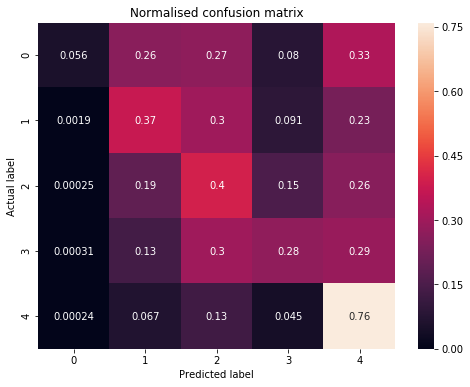

In [105]:
plot_average_confmatrix(lgb_confusion_matrices)

There are some interesting patterns here (the exact values will vary a little):
- Only 5.6% of actual 0s are accurately classified. Of those that are misclassified, 33% are wrongly considered category 4, with the almost all the rest split evenly between 1 and 2.
- 37% of 1s are correctly classified. However, 30% are misclassified as 2s and a further 26% as 4s.
- 28% of 3s are correct, with 30% wrong classified as 2s and 29% as 4s.

This suggests that some form of redistributing the classifications might improve the overall accuracy (and, more importantly, QWK score) of the model. Luckily, some Kaggle users with more knowledge/experience than me have already gone down this route. What follows in the next section is an implementation of what appears to currently be the most popular solution.

## LightGBM: regression model

In the previous section I fitted a LightGBM classification model to the training data. This did not perform as well as hoped, seemingly regardless of hyperparameter values, with an average overall QWK score of between about 0.399 and 0.400.